# ADS 509 Assignment 2.1: Tokenization, Normalization, Descriptive Statistics 

This notebook holds Assignment 2.1 for Module 2 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In the previous assignment you pulled lyrics data on two artists. In this assignment we explore this data set and a pull from the now-defunct Twitter API for the artists Cher and Robyn.  If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Canvas. 

This assignment asks you to write a short function to calculate some descriptive statistics on a piece of text. Then you are asked to find some interesting and unique statistics on your corpora. 


In [80]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kevinbaum/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [81]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation

sw = stopwords.words("english")

In [82]:
# Add any additional import statements you need here

# import os to aid in reading in the data
import os
import matplotlib.pyplot as plt

KB: I commented out the below file switching code as I decided to simply move the twitter and lyrics files into the current directory I am already in. Thus, when I push this to github and you download it, the files will already be in the same directory together

In [83]:
# change `data_location` to the location of the folder on your machine.
# data_location = "/users/chandler/dropbox/teaching/repos/ads-tm-api-scrape/"

In [84]:
# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

In [85]:
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # Fill in the correct values here. 

    # num_tokens is the length of the text that gets passed into the function
    num_tokens = len(tokens)

    # num_unique_tokens contains the "set" data type, which represents a 
    # collection of unique elements. It lets us get a unique count of 
    # different words in the text.
    num_unique_tokens = len(set(tokens))

    # To get lexical diversity, we divide the number of unique tokens
    # by the total. If the number of unique tokens is identical to the 
    # total, then we get a perfect lexical diversity of 1. 
    lexical_diversity = num_unique_tokens / num_tokens

    # We use a for loop here to access the letters within the tokens.
    # To do this, we take a length of each word within the text, 
    # then sum it.
    num_characters = sum(len(token) for token in tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        # "Counter" comes from the "collections" module that we imported above. 
        # It lets us pass in the number of tokens to make it into a "Counter"
        # object that we can then 
        common_tokens = Counter(tokens).most_common(num_tokens)
        print(f"The {num_tokens} most common tokens are: {common_tokens}")
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    

In [86]:
text = """here is some example text with other example text here in this text""".split()
assert(descriptive_stats(text, verbose=True)[0] == 13)
assert(descriptive_stats(text, verbose=False)[1] == 9)
assert(abs(descriptive_stats(text, verbose=False)[2] - 0.69) < 0.02)
assert(descriptive_stats(text, verbose=False)[3] == 55)


There are 13 tokens in the data.
There are 9 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.692 in the data.
The 13 most common tokens are: [('text', 3), ('here', 2), ('example', 2), ('is', 1), ('some', 1), ('with', 1), ('other', 1), ('in', 1), ('this', 1)]


Q: Why is it beneficial to use assertion statements in your code? 

A: Assertion statements help the proper functioning of the code. By asserting that a condition is true at a specific point in the code, you can catch errors. Meaning, if an error is produced, that means there is a flaw in the logic and there is less to disentangle later had the assertion statement not been used. In this way, assertion statements validate the code is working as expected and can cut down the time it takes to handle errors and bugs. 

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [87]:
# Read in the lyrics data
def read_lyrics_data(folder_path):
    # Set up the dictionary for storing the data
    lyrics_data = defaultdict(dict)

    # Use the imported os dictionary, which lets us access the underlying
    # operating system being run and treats it kind of like an API that
    # it is interacting with. 
    # "os.walk()" is a generator that walks a dictionary tree and returns
    # a tuple of 3 values (root, dirs, files). The whole purpose of this is to 
    # access the files via code within the directories and get the information
    # out of them to put into the dictionary we set up.
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            
            # Extract information when dealing with the text files
            if file.endswith(".txt"):
                
                # Divides up the artist and song based on the underscore
                artist, song = file[:-4].split('_') 

                # Read in the data by opening the files and using f.read() 
                with open(os.path.join(root, file), 'r', encoding='utf-8') as f:
                    lyrics_data[artist][song] = f.read()
    return lyrics_data

# We use the "lyrics" prefix to access the contents of the lyrics folder
lyrics_folder = "lyrics/"
lyrics_data = read_lyrics_data(lyrics_folder)

In [88]:
def read_twitter_data(folder_path):
    # Setting up a twitter_data dictionary to store the information in
    twitter_data = {}

    # Iterate over each file in the directory for twitter data
    for file in os.listdir(folder_path):
        
        # Performs the text reading when dealing with the txt files
        if file.endswith(".txt"):
            
            # Construct the file path
            file_path = os.path.join(folder_path, file)
            
            # Open the file for reading
            with open(file_path, 'r', encoding='utf-8') as f:
    
                # Reads all lines from the file and "lines" list
                lines = f.readlines()
    
                # Extract the "description" field which is the 7th (0-indexed)
                # field in the tab separated twitter data files
                descriptions = [line.split('\t')[6] for line in lines[1:] if len(line.split('\t')) > 6]
    
                # Extract the artist name by removing ".txt" from the suffix
                artist = file[:-4]
    
                # The descriptions are stored in the twitter_data dictionary with the artist's name as the key.
                twitter_data[artist] = descriptions
    return twitter_data

twitter_folder = "twitter/"
twitter_data = read_twitter_data(twitter_folder)

## Data Cleaning

Now clean and tokenize your data. Remove punctuation chacters (available in the `punctuation` object in the `string` library), split on whitespace, fold to lowercase, and remove stopwords. Store your cleaned data, which must be accessible as an interable for `descriptive_stats`, in new objects or in new columns in your data frame. 



In [89]:
punctuation = set(punctuation) # speeds up comparison

# This function takes in takes a string text, removes punctuation, 
# tokenizes it into words, converts to lowercase, and removes stopwords. 
# The result is a list of clean tokens.
def clean_and_tokenize(text, keep_hashtags=True):
    """Function to clean and tokenize a given text."""
    # Modify punctuation set to keep '#' if keep_hashtags is True
    if keep_hashtags:
        modified_punctuation = set(punctuation) - set('#')
    else:
        modified_punctuation = set(punctuation)
        
    # Remove punctuation
    text = ''.join(ch for ch in text if ch not in modified_punctuation)
    # Tokenize and convert to lowercase
    tokens = text.lower().split()
    # Remove stopwords
    tokens = [word for word in tokens if word not in sw]
    return tokens

In [90]:
# create your clean twitter data here
clean_twitter_data = {}
for artist, descriptions in twitter_data.items():

    # Clean the twitter data descriptions using the function
    clean_descriptions = [clean_and_tokenize(desc) for desc in descriptions]
    clean_twitter_data[artist] = clean_descriptions

In [91]:
# create your clean lyrics data here
clean_lyrics_data = {}
for artist, songs in lyrics_data.items():
    clean_songs = {}
    for song, lyrics in songs.items():
        clean_songs[song] = clean_and_tokenize(lyrics)
    clean_lyrics_data[artist] = clean_songs

## Basic Descriptive Statistics

Call your `descriptive_stats` function on both your lyrics data and your twitter data and for both artists (four total calls). 

In [92]:
# calls to descriptive_stats here

# For Lyrics Data
all_lyrics_artist1 = [token for song in clean_lyrics_data['jonimitchell'].values() for token in song]
all_lyrics_artist2 = [token for song in clean_lyrics_data['kanyewest'].values() for token in song]

# For Twitter Data
all_tweets_artist1 = [token for tweet in clean_twitter_data['cher_followers_data'] for token in tweet]
all_tweets_artist2 = [token for tweet in clean_twitter_data['robynkonichiwa_followers_data'] for token in tweet]

# Descriptive Stats Calls
print("Lyrics Data - Joni Mitchell:")
descriptive_stats(all_lyrics_artist1)

print("\nLyrics Data - Kanye West:")
descriptive_stats(all_lyrics_artist2)

print("\nTwitter Data - Cher:")
descriptive_stats(all_tweets_artist1)

print("\nTwitter Data - Robyn:")
descriptive_stats(all_tweets_artist2)

Lyrics Data - Joni Mitchell:
There are 2649 tokens in the data.
There are 1642 unique tokens in the data.
There are 16876 characters in the data.
The lexical diversity is 0.620 in the data.
The 2649 most common tokens are: [('know', 31), ('like', 23), ('dont', 23), ('love', 19), ('come', 17), ('think', 17), ('morning', 16), ('one', 15), ('never', 13), ('go', 11), ('ask', 11), ('still', 10), ('comes', 10), ('say', 10), ('heart', 10), ('looked', 9), ('back', 9), ('wont', 9), ('children', 9), ('always', 8), ('another', 8), ('rain', 8), ('saw', 8), ('see', 8), ('find', 8), ('dreams', 8), ('take', 7), ('fit', 7), ('city', 7), ('light', 7), ('gotten', 7), ('man', 7), ('found', 7), ('lady', 6), ('would', 6), ('let', 6), ('day', 6), ('ill', 6), ('heard', 6), ('cant', 6), ('night', 6), ('said', 6), ('youre', 6), ('shes', 6), ('playing', 6), ('sun', 6), ('thats', 6), ('came', 6), ('knows', 6), ('aging', 6), ('may', 5), ('sides', 5), ('clouds', 5), ('life', 5), ('win', 5), ('king', 5), ('im', 5),

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[1495780, 258391, 0.17274666060516922, 9158569]

Q: How do you think the "top 5 words" would be different if we left stopwords in the data? 

A: Without removing the stopwords, the top 5 words would be much more likely to be words like "the," "is," "at," or "which." If we decided not to get rid of them, they would appear much more frequently than other, more meaningful words. Having said that, in both Kanye and Joni we see some similarities. 

For Joni, the top 5 words are: ('know', 31), ('like', 23), ('dont', 23), ('love', 19), ('come', 17)

For Kanye, the top 5 words are: ('get', 153), ('like', 135), ('im', 106), ('know', 89), ('aint', 83)

As we can see, both of them contain the words "know," "like," and a variation of "do not" with "dont" and "aint." Thus, even after removing the stop words, there are still some that don't have a lot of importance. 

---

Q: What were your prior beliefs about the lexical diversity between the artists? Does the difference (or lack thereof) in lexical diversity between the artists conform to your prior beliefs? 

A: Joni has a much higher lexical diversity at 0.620 than Kanye does at 0.385. I would not have previously expected the lexical diversity to be much different between the two artists. I believe both are very poetic in how they write their songs. What is interesting is that Kanye's 25 songs contain much more content per song than Joni's 25 songs. Joni's songs contain 2649 words, while Kanye's songs contain 8496 words. That's more than 3 times as many words! However, he obviously repeats a lot of words given the relative lack of lexical diversity. 


## Specialty Statistics

The descriptive statistics we have calculated are quite generic. You will now calculate a handful of statistics tailored to these data.

1. Ten most common emojis by artist in the twitter descriptions.
1. Ten most common hashtags by artist in the twitter descriptions.
1. Five most common words in song titles by artist. 
1. For each artist, a histogram of song lengths (in terms of number of tokens) 

We can use the `emoji` library to help us identify emojis and you have been given a function to help you.


In [93]:
assert(emoji.is_emoji("❤️"))
assert(not emoji.is_emoji(":-)"))

### Emojis 😁

What are the ten most common emojis by artist in the twitter descriptions? 


In [94]:
# Your code here

# Define the function to gather the most common emojis, with twitter_data and
# number of emojis = 10 passed in as the arguments
def most_common_emojis(twitter_data, num_emojis=10):

    # Initialize and empty dictionary to store counts in
    emoji_counts = {}

    # Use a for loop to search for artist and descriptions within the twitter data
    for artist, descriptions in twitter_data.items():

        # Outer loop: "for tweet in descriptions" iterates over each tweet in the descriptions
        # Inner loop: "for token in tweet" takes the tweet obtained from the outer loop and iterates
        # over each token in the tweet.
        # Conditional statement: returns "True" if the token is an emoji
        # Finally, use a list comprehension ("[]") to construct a list of emojis found in all tweets 
        # in descriptions.
        all_emojis = [token for tweet in descriptions for token in tweet if emoji.is_emoji(token)]

        # Gets the top 10 most common emojis
        emoji_counts[artist] = Counter(all_emojis).most_common(num_emojis)
    return emoji_counts

# Calculate the most common emojis for each artist
common_emojis_by_artist = most_common_emojis(clean_twitter_data)

# Print the results
for artist, emojis in common_emojis_by_artist.items():
    print(f"{artist}: {emojis}")

cher_followers_data: [('❤️', 14715), ('🏳️\u200d🌈', 14122), ('♥', 10154), ('❤', 9651), ('✨', 8343), ('🌈', 5474), ('🇺🇸', 3696), ('💙', 3684), ('💜', 3499), ('🌊', 3278)]
robynkonichiwa_followers_data: [('🏳️\u200d🌈', 1701), ('♥', 1167), ('❤️', 987), ('✨', 751), ('❤', 653), ('🌈', 570), ('🎶', 272), ('🎧', 213), ('🖤', 212), ('💜', 205)]
cher_followers: []
robynkonichiwa_followers: []


### Hashtags

What are the ten most common hashtags by artist in the twitter descriptions? 

In [95]:
# Your code here

# Set up the most common hashtags
def most_common_hashtags(twitter_data, num_hashtags=10):

    # Initialize the hashtag_counts dictionary
    hashtag_counts = {}
    for artist, descriptions in twitter_data.items():
        all_hashtags = [token for tweet in descriptions for token in tweet if token.startswith('#')]
        hashtag_counts[artist] = Counter(all_hashtags).most_common(num_hashtags)
    return hashtag_counts

# Calculate the most common hashtags for each artist
common_hashtags_by_artist = most_common_hashtags(clean_twitter_data)

# Print the results
for artist, hashtags in common_hashtags_by_artist.items():
    print(f"{artist}: {hashtags}")


cher_followers_data: [('#resist', 10540), ('#blm', 9582), ('#blacklivesmatter', 7775), ('#theresistance', 3211), ('#fbr', 3131), ('#resistance', 2788), ('#1', 2423), ('#', 2128), ('#voteblue', 2062), ('#lgbtq', 1791)]
robynkonichiwa_followers_data: [('#blacklivesmatter', 584), ('#blm', 340), ('#music', 289), ('#1', 194), ('#', 168), ('#teamfollowback', 127), ('#edm', 108), ('#lgbtq', 81), ('#resist', 80), ('#art', 69)]
cher_followers: []
robynkonichiwa_followers: []


### Song Titles

What are the five most common words in song titles by artist? The song titles should be on the first line of the lyrics pages, so if you have kept the raw file contents around, you will not need to re-read the data.


In [96]:
# Your code here

# Function to find the most common words in song titles
def most_common_words_in_titles(lyrics_data, num_words=5):
    title_word_counts = {}
    for artist, songs in lyrics_data.items():
        all_title_words = []
        for song, lyrics in songs.items():
            
            # Split the lyrics by the return lines
            title = lyrics.split('\n')[0] 
            
            title_words = clean_and_tokenize(title)

            # ".extend" is used to add the elements of the list 
            # title_words to the end of the list all_title_words
            all_title_words.extend(title_words)
        title_word_counts[artist] = Counter(all_title_words).most_common(num_words)
    return title_word_counts

# Calculate the most common words in song titles for each artist
common_words_by_artist = most_common_words_in_titles(lyrics_data)

# Print the results
for artist, common_words in common_words_by_artist.items():
    print(f"{artist}: {common_words}")

jonimitchell: [('morning', 2), ('song', 2), ('ladies', 1), ('canyon', 1), ('sides', 1)]
kanyewest: [('skit', 3), ('school', 3), ('spirit', 3), ('workout', 2), ('plan', 2)]


### Song Lengths

For each artist, a histogram of song lengths (in terms of number of tokens). If you put the song lengths in a data frame with an artist column, matplotlib will make the plotting quite easy. An example is given to help you out. 


artist
Artist 1    Axes(0.125,0.11;0.775x0.77)
Artist 2    Axes(0.125,0.11;0.775x0.77)
Name: length, dtype: object

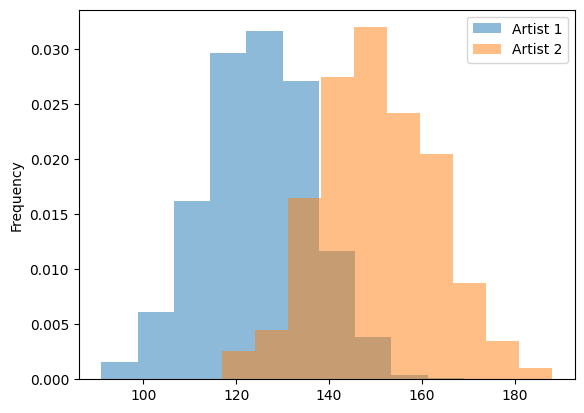

In [97]:
num_replicates = 1000

df = pd.DataFrame({
    "artist" : ['Artist 1'] * num_replicates + ['Artist 2']*num_replicates,
    "length" : np.concatenate((np.random.poisson(125,num_replicates),np.random.poisson(150,num_replicates)))
})

df.groupby('artist')['length'].plot(kind="hist",density=True,alpha=0.5,legend=True)

Since the lyrics may be stored with carriage returns or tabs, it may be useful to have a function that can collapse whitespace, using regular expressions, and be used for splitting. 

Q: What does the regular expression `'\s+'` match on? 

A: The regular expression `'\s+'` matches one or more whitespace characters in a string. This includes spaces (' '), tabs ('\t'), newlines ('\n'), and carriage returns ('\r'). The `+` is a quantifier in regular expressions. It matches one or more occurrences of the preceding element. In this case, it applies to the \s, meaning the expression will match sequences of one or more consecutive whitespace characters. 


In [100]:
collapse_whitespace = re.compile(r'\s+')

def tokenize_lyrics(lyric) : 
    """strip and split on whitespace"""
    return([item.lower() for item in collapse_whitespace.split(lyric)])

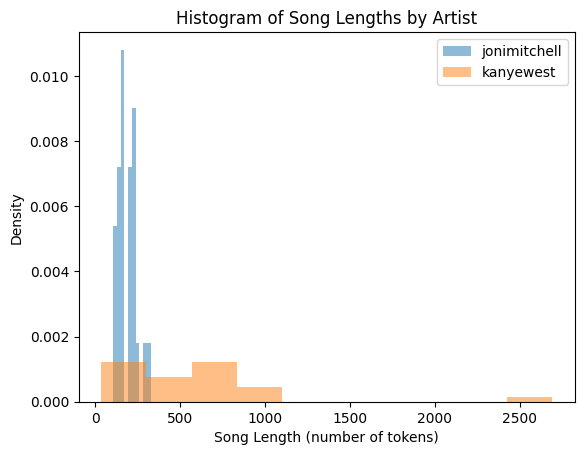

In [102]:
# Your lyric length comparison chart here. 

# Calculate song lengths

# Initialize list
song_lengths = []

for artist, songs in lyrics_data.items():
    for song, lyrics in songs.items():
        tokens = tokenize_lyrics(lyrics)
        length = len(tokens)
        song_lengths.append({'artist': artist, 'length': length})

# Create DataFrame
df = pd.DataFrame(song_lengths)

# Plotting
df.groupby('artist')['length'].plot(kind="hist", density=True, alpha=0.5, legend=True)
plt.xlabel("Song Length (number of tokens)")
plt.ylabel("Density")
plt.title("Histogram of Song Lengths by Artist")
plt.show()